In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
#os.chdir('data')
#from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
#sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [197]:
# Open dataset with column names as in gridwatch.csv
df = pd.read_csv('gridwatch.csv', header=0, delimiter=",", names=['timestamp', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar'])

# Keep only timestamp and coal columns
df = df[['timestamp', 'coal']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.shape)
df.head()


(796453, 2)


,timestamp,coal
62694,2012-01-01 00:00:01,8693
62695,2012-01-01 00:05:06,8650
62696,2012-01-01 00:10:01,8880
62697,2012-01-01 00:15:01,9111
62698,2012-01-01 00:20:01,9195


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

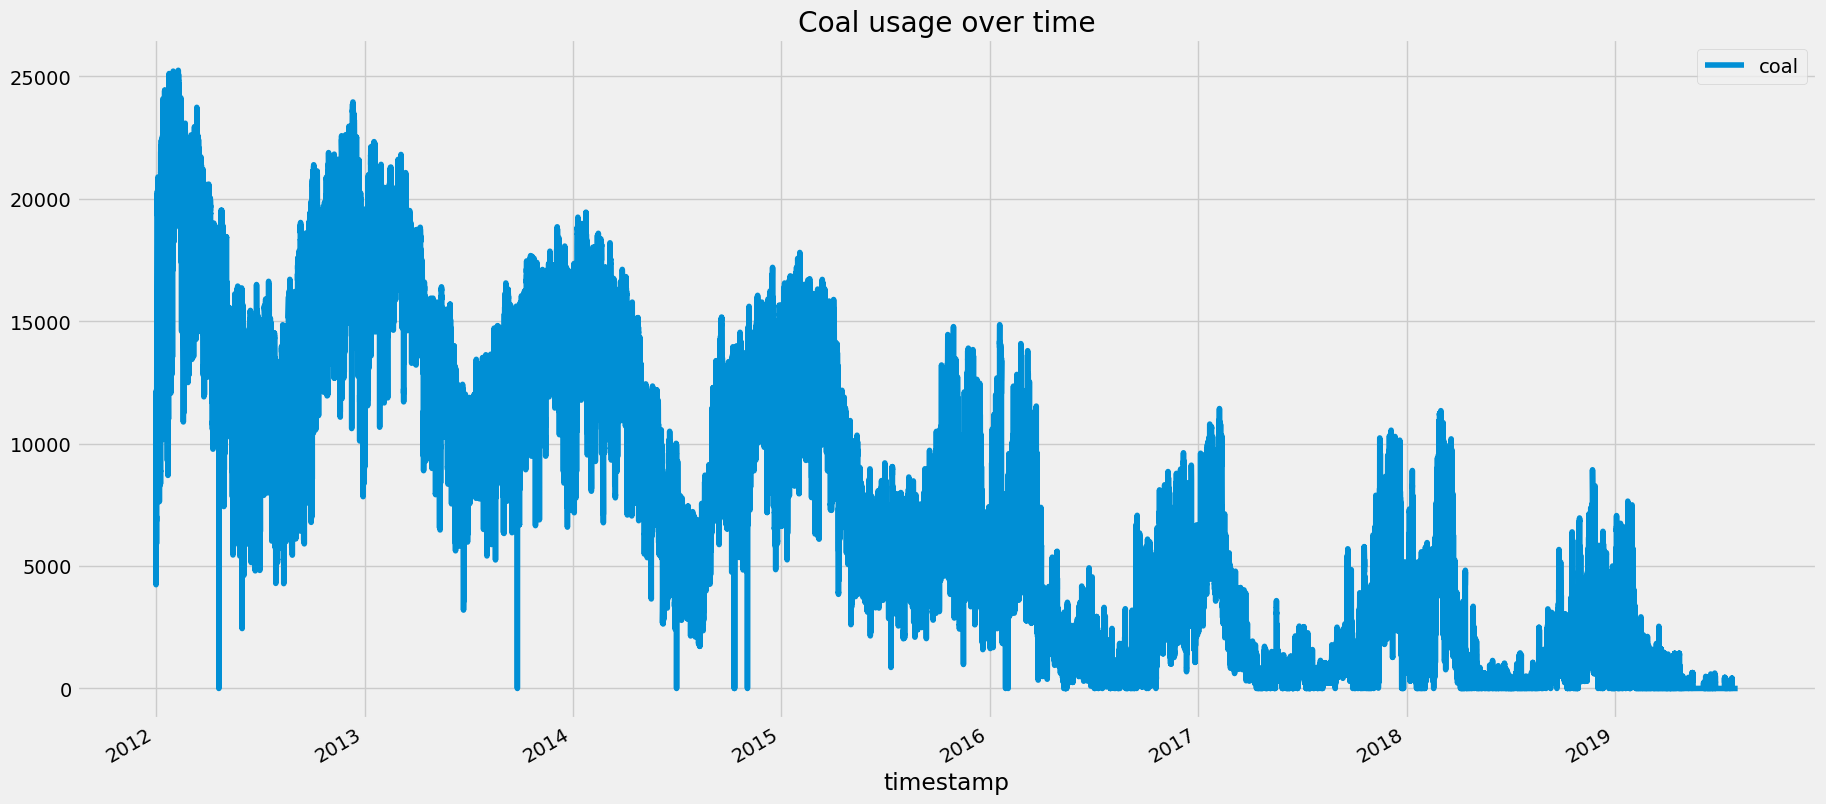

In [198]:
# Plot the coal usage column over time 
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')


(2772, 2)
(1461, 2)
(1311, 2)


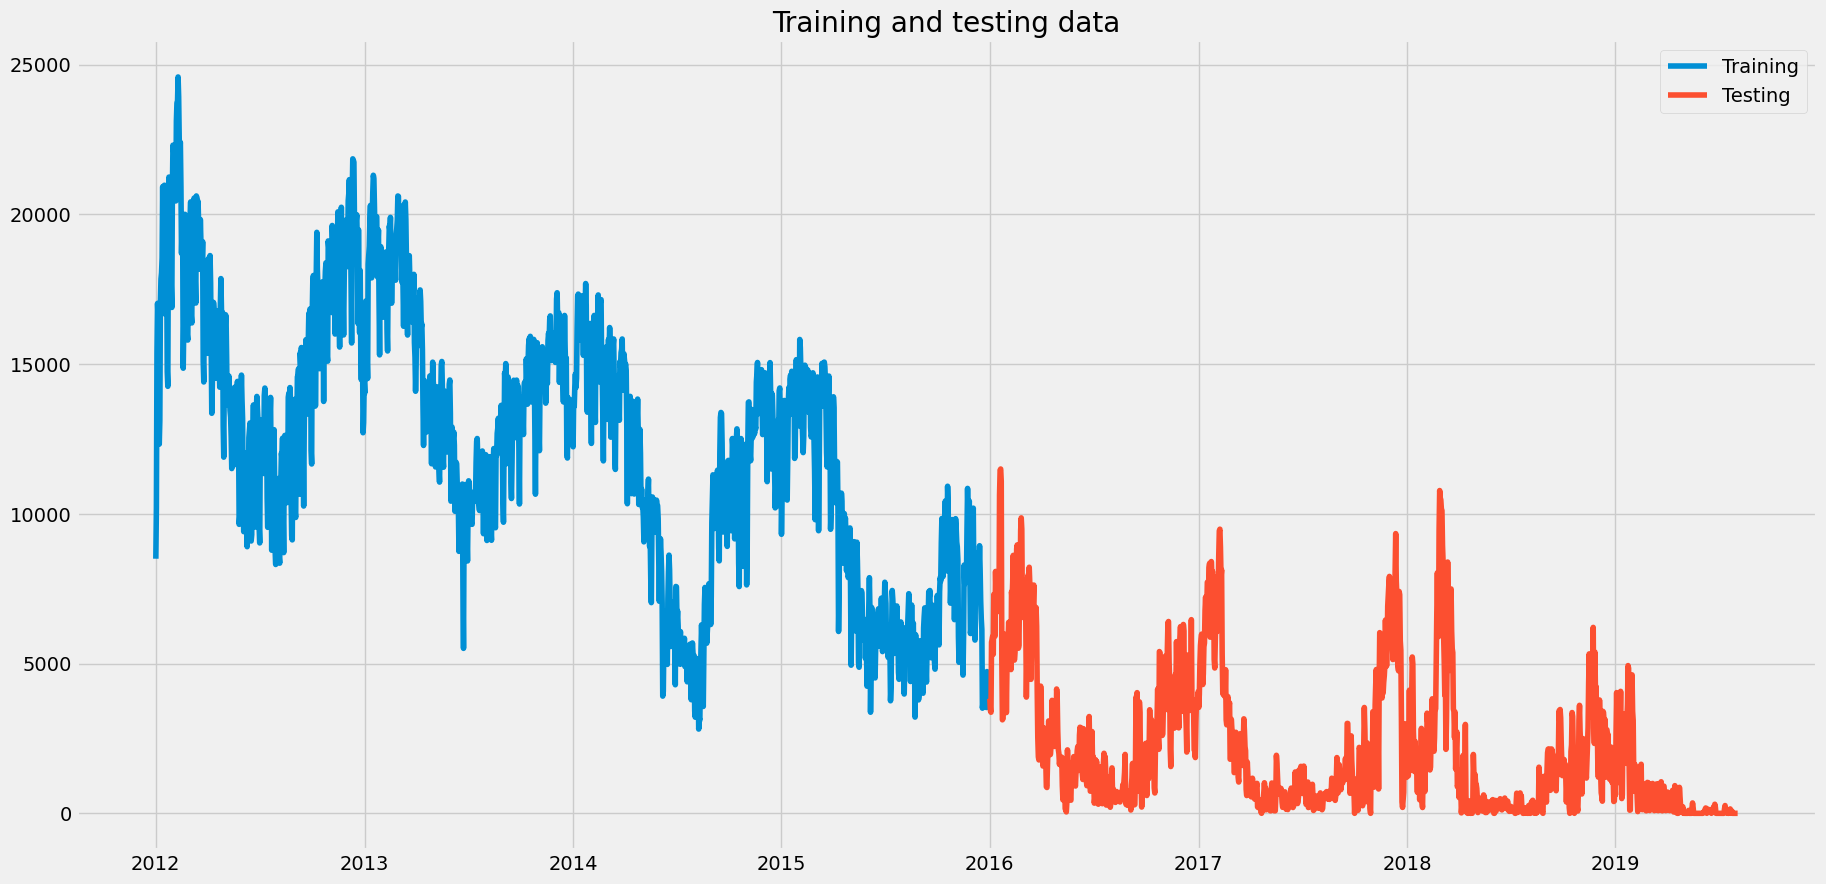

In [199]:
# Pre-process coal data to get the average coal usage per day
dfDay = df
dfDay = dfDay.set_index('timestamp')
dfDay = dfDay.resample('D').mean()
dfDay = dfDay.reset_index()
print(dfDay.shape)
dfDay.head()

# Separate the dfDay dataframe into two dataframes, one for training and one for testing
dfDayTrain = dfDay[dfDay['timestamp'] < '2016-01-01']
dfDayTest = dfDay[dfDay['timestamp'] >= '2016-01-01']
print(dfDayTrain.shape)
print(dfDayTest.shape)

# timestamp to index
dfDayTrain = dfDayTrain.set_index('timestamp')
dfDayTest = dfDayTest.set_index('timestamp')

# Plot the training and testing dataframes with matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain.index, dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest.index, dfDayTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()




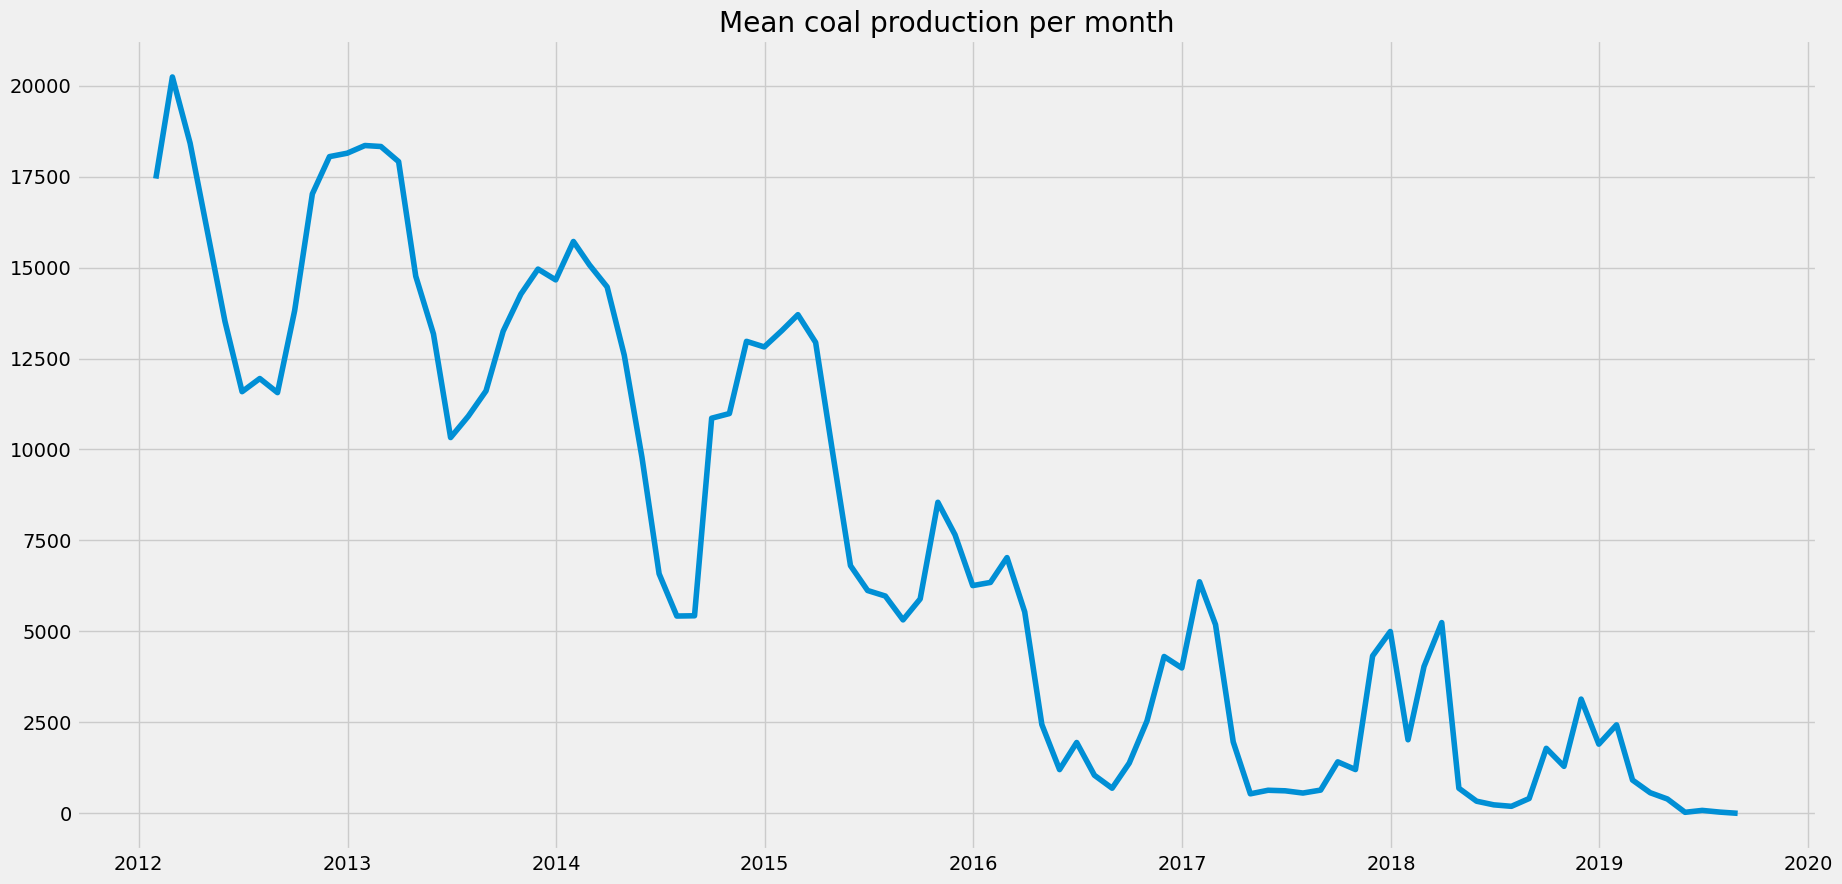

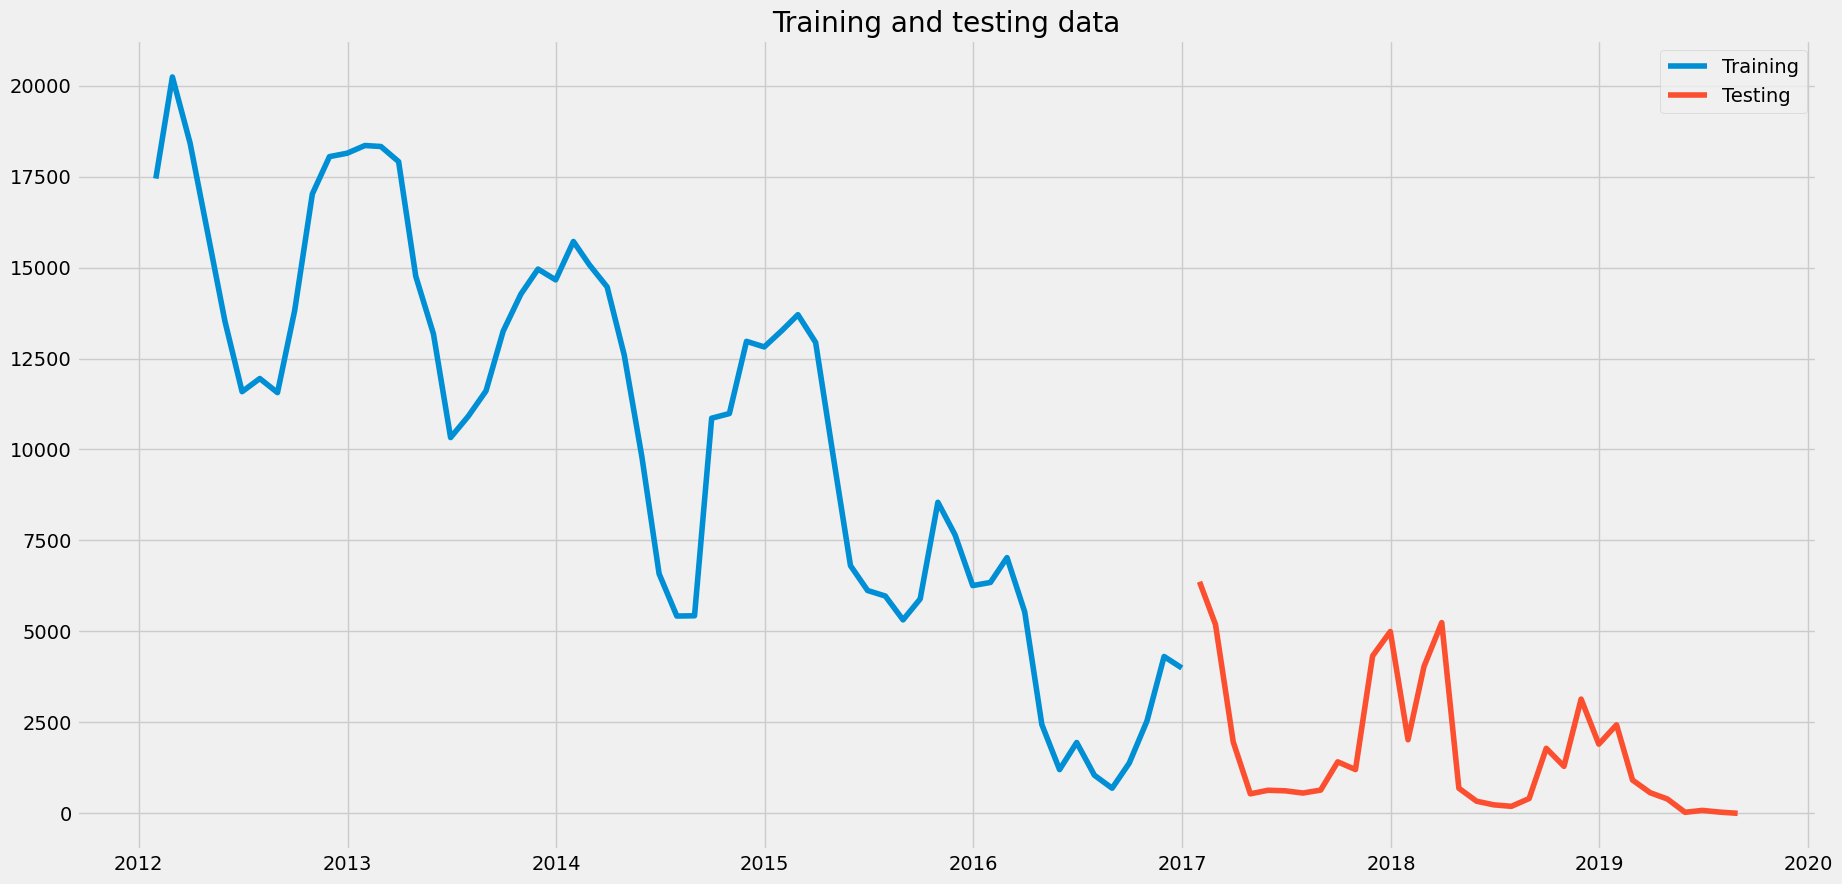

In [200]:
# Create a reduced dataframe with only the timestamp and the coal column
dfMonth = dfDay[['timestamp', 'coal']].copy()

# Mean of the coal column per month
dfMonth = dfMonth.groupby(pd.Grouper(key='timestamp', freq='M')).mean()
dfMonth.head()

# Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonth.index, dfMonth['coal'])
ax.set_title('Mean coal production per month')
fig.show()

# Split the data in training and testing data
dfMonthTrain = dfMonth[:'2016-12-31']
dfMonthTest = dfMonth['2017-01-31':]

# Plot the training and testing data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()



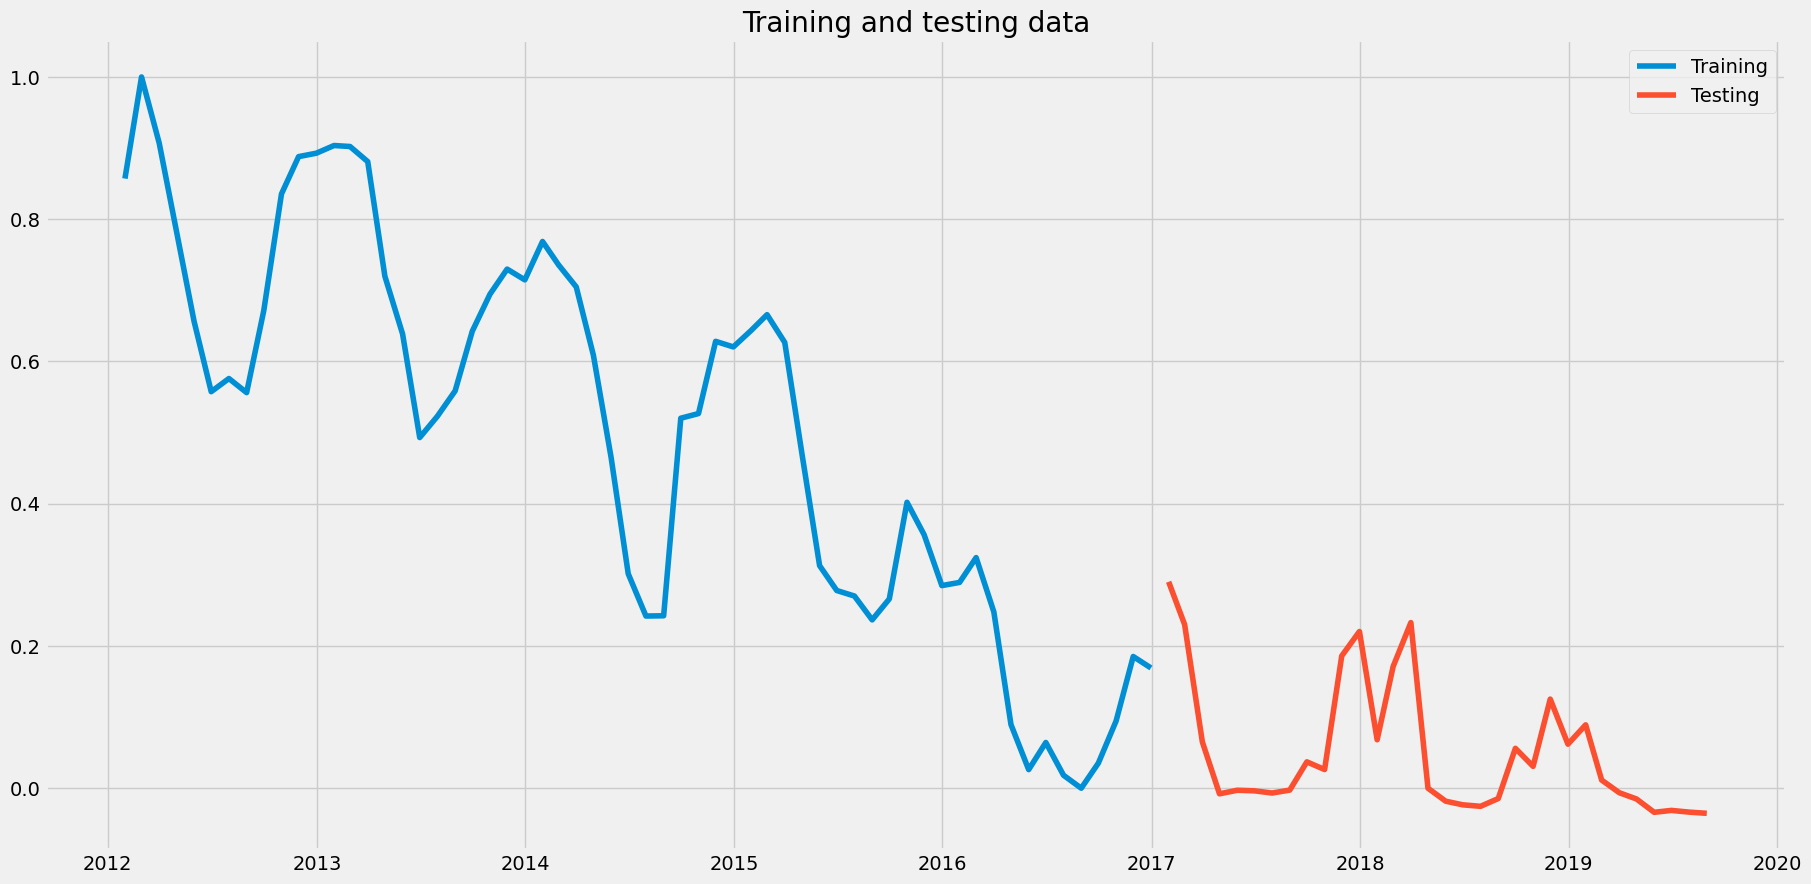

In [201]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
dfMonthTrainScaled = scaler.fit_transform(dfMonthTrain)
dfMonthTestScaled = scaler.transform(dfMonthTest)

# add timestamp column to the normalized data
dfMonthTrainScaled = pd.DataFrame(dfMonthTrainScaled, columns=['coal'])
dfMonthTrainScaled['timestamp'] = dfMonthTrain.index
dfMonthTrainScaled = dfMonthTrainScaled[['timestamp', 'coal']]
dfMonthTestScaled = pd.DataFrame(dfMonthTestScaled, columns=['coal'])
dfMonthTestScaled['timestamp'] = dfMonthTest.index
dfMonthTestScaled = dfMonthTestScaled[['timestamp', 'coal']]
dfMonthTrainScaled.head()

# Plot the normalized data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrainScaled['timestamp'], dfMonthTrainScaled['coal'], label='Training')
ax.plot(dfMonthTestScaled['timestamp'], dfMonthTestScaled['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()



In [202]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [203]:
n_input = 30
n_features = 1
print(n_input)
print(n_features)


# Create a TimeseriesGenerator object
generator = TimeseriesGenerator(dfMonthTrainScaled['coal'], dfMonthTrainScaled['coal'], length=n_input, batch_size=1)

print(len(generator))



30
1
30


In [204]:
# Create the model
model = Sequential()
# RNN
model.add(SimpleRNN(100, activation='relu', input_shape=(n_input, n_features)))
# Dense layer
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')




In [205]:
# Fit the model
model.fit_generator(generator,epochs=50)



Epoch 1/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 13/50
30/30 [==============================

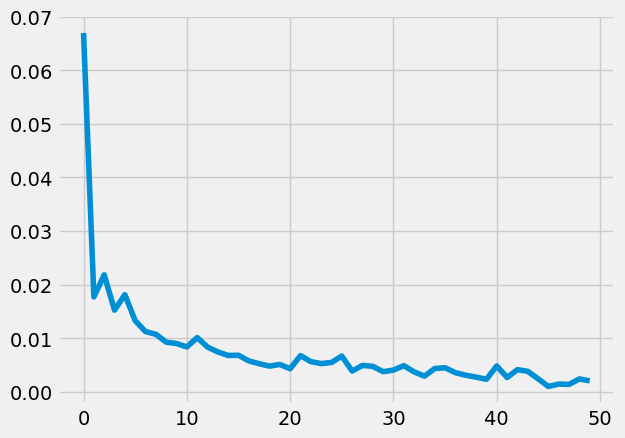

In [206]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.show()


1/1 [==============================] - 0s 13ms/step


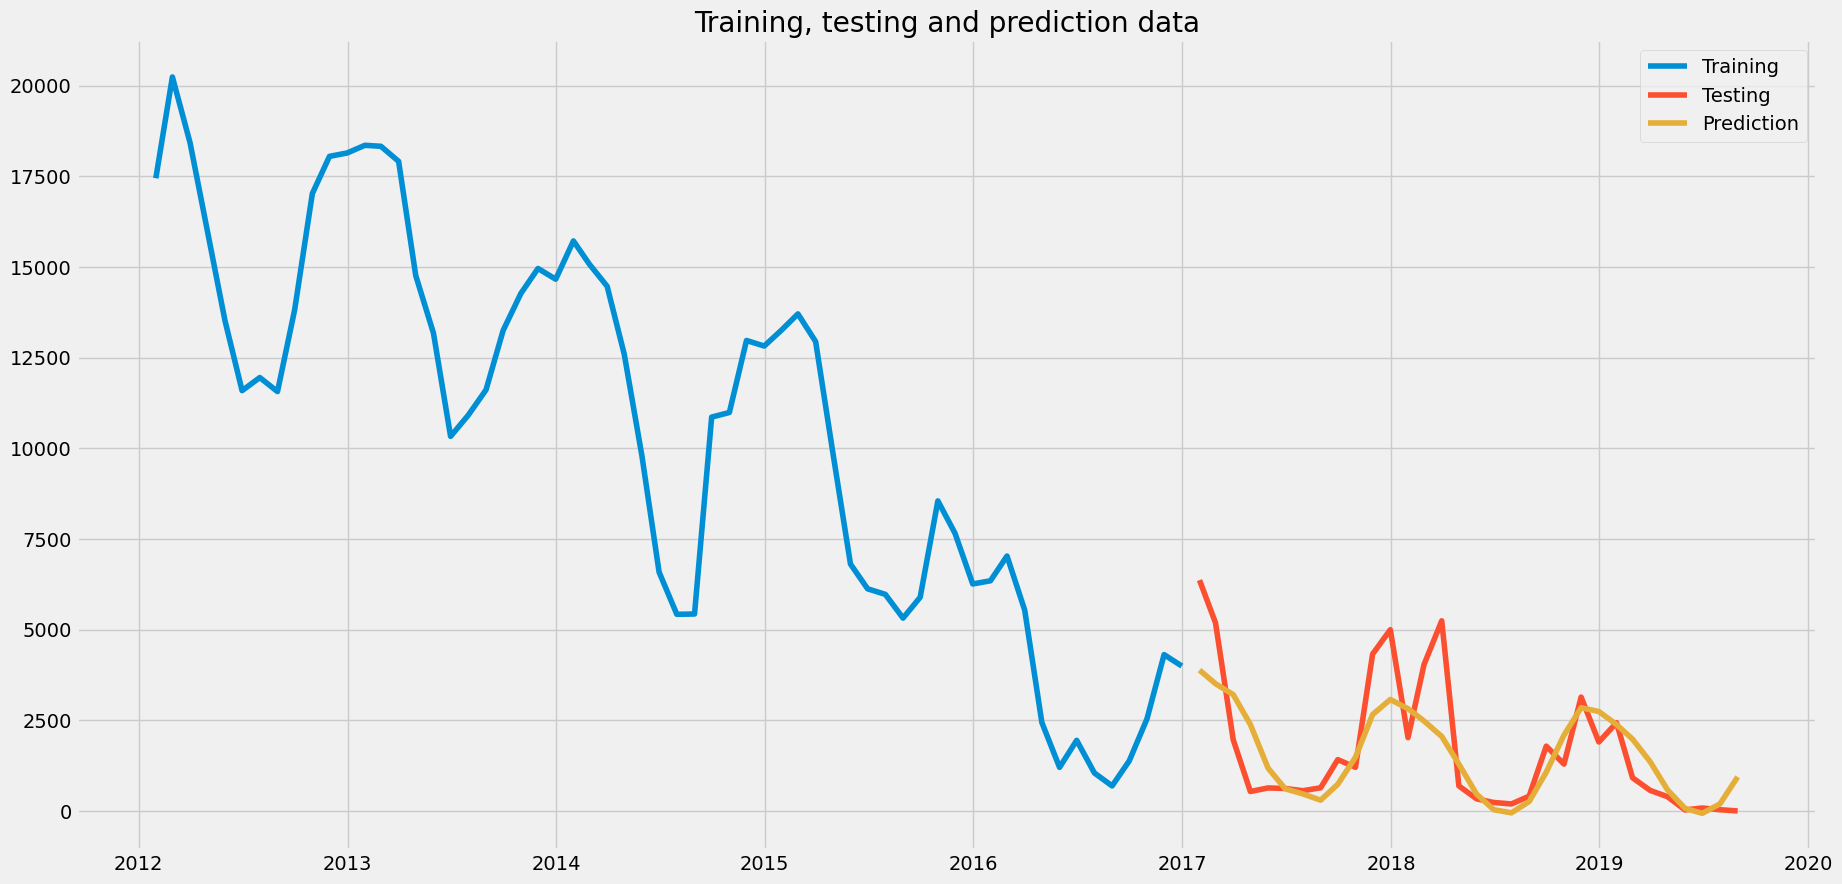

In [207]:
# Predict the values
first_eval_batch = pd.DataFrame(dfMonthTrainScaled['coal'][-n_input:])
first_eval_batch = first_eval_batch.values.reshape((1, n_input, n_features))

# Predictions for the next 12 months
test_predictions = []

# Last n_input points from the training set
current_batch = first_eval_batch

# How far into the future will we predict?
n_predictions = 32

# Predict for the next 12 months
for i in range(n_predictions):
        
        # Get the prediction value for the current batch
        current_pred = model.predict(current_batch)[0]
        
        # Store the prediction
        test_predictions.append(current_pred) 
        
        # Update the batch to now include the predicted value
        # and drop the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transform the predictions
true_predictions = scaler.inverse_transform(test_predictions)

# Index of the predictions
true_predictions = pd.DataFrame(index=dfMonthTest.index[:n_predictions], data=true_predictions, columns=['Prediction'])
# Plot the predictions
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.plot(true_predictions.index, true_predictions['Prediction'], label='Prediction')
ax.set_title('Training, testing and prediction data')
ax.legend()
fig.show()

